1. Identify all molecules that contain a carboxyl group
2. Identify all the torsion angles that involve that carboyl group
3. Plot and see -- would expect there to be two modes separated by 180 degrees, sampled at least a little bit -- what's the relaxation time for this flip?
4. If any of this can be automated, put it in `bayes-implicit-solvent`

In [1]:
from bayes_implicit_solvent.solvation_free_energy import smiles_list, db, mol_top_sys_pos_list

In [31]:
for i in range(len(db)):
    if db[i][2] == 'methyl formate':
        print(i)
        print(db[i])
        break

43
['mobley_1717215', 'COC=O', 'methyl formate', '-2.78', '0.60', '-4.03', '0.02', '10.1021/ct050097l', '10.1021/ct800409d', 'Experimental uncertainty not presently available, so assigned a default value.  ']


In [32]:
smiles = db[i][1]

In [33]:
for j in range(len(smiles_list)):
    if smiles_list[j] == smiles:
        print(j)
        break

583


In [34]:
smiles_list[j]

'COC=O'

In [35]:
len(smiles_list), len(mol_top_sys_pos_list)

(642, 642)

In [36]:
mol, top, sys, pos = mol_top_sys_pos_list[j]
atoms = [a.GetName() for a in mol.GetAtoms()]
atoms

['C1', 'C2', 'O1', 'O2', 'H1', 'H2', 'H3', 'H4']

In [37]:
len(atoms)

8

In [41]:
methyl_formate_traj_name = '../bayes_implicit_solvent/vacuum_samples/vacuum_samples_583.h5'

In [42]:
import mdtraj as md
traj = md.load(methyl_formate_traj_name)

In [43]:
traj

<mdtraj.Trajectory with 10000 frames, 8 atoms, 1 residues, without unitcells at 0x12c3702e8>

In [44]:
def bonds_share_an_atom(bond1, bond2):
    return bond1[1] == bond2[0]
    #return len(set(bond1 + bond2)) < 4

def get_torsion_tuples(traj):
    """dumb brute-force O(n_bonds^3) iteration"""
    
    bonds = list([(a.index, b.index) for (a,b) in traj.top.bonds]) + list([(b.index, a.index) for (a,b) in traj.top.bonds])
    torsions = []
    for bond1 in bonds:
        for bond2 in bonds:
            for bond3 in bonds:
                if bonds_share_an_atom(bond1, bond2) and bonds_share_an_atom(bond2, bond3):
                    putative_torsion = (bond1[0], bond1[1], bond2[1], bond3[1])
                    if putative_torsion[-1] < putative_torsion[0]:
                        putative_torsion = putative_torsion[::-1]
                    if len(set(putative_torsion)) == 4:
                        torsions.append(putative_torsion)
    
    return sorted(list(set(torsions)))

In [45]:
torsions= get_torsion_tuples(traj)
len(torsions)

5

In [46]:
import pyemma
feat = pyemma.coordinates.featurizer(traj.topology)
feat.add_dihedrals(torsions, cossin=True)
X = feat.transform(traj)

In [47]:

tica = pyemma.coordinates.tica(X, lag=20)
tica.timescales[0]

22.984870308329935

In [48]:
X.shape

(10000, 10)

In [49]:
y = tica.get_output()[0]

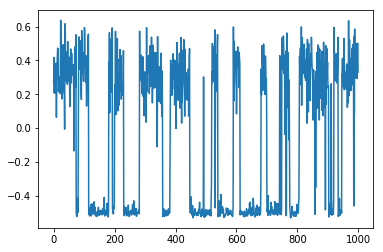

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(y[:,0][:1000])

In [51]:
feat.describe()

['DIH: COS( 0 C1 0 -   0 O2 3 -  0 C2 1 -  0 H2 5)',
 'DIH: SIN( 0 C1 0 -   0 O2 3 -  0 C2 1 -  0 H2 5)',
 'DIH: COS( 0 C1 0 -   0 O2 3 -  0 C2 1 -  0 H3 6)',
 'DIH: SIN( 0 C1 0 -   0 O2 3 -  0 C2 1 -  0 H3 6)',
 'DIH: COS( 0 C1 0 -   0 O2 3 -  0 C2 1 -  0 H4 7)',
 'DIH: SIN( 0 C1 0 -   0 O2 3 -  0 C2 1 -  0 H4 7)',
 'DIH: COS( 0 C2 1 -   0 O2 3 -  0 C1 0 -  0 O1 2)',
 'DIH: SIN( 0 C2 1 -   0 O2 3 -  0 C1 0 -  0 O1 2)',
 'DIH: COS( 0 C2 1 -   0 O2 3 -  0 C1 0 -  0 H1 4)',
 'DIH: SIN( 0 C2 1 -   0 O2 3 -  0 C1 0 -  0 H1 4)']

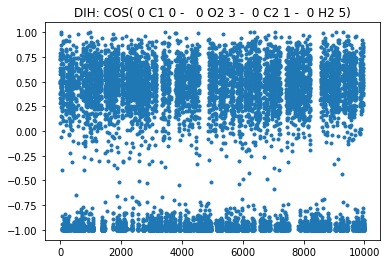

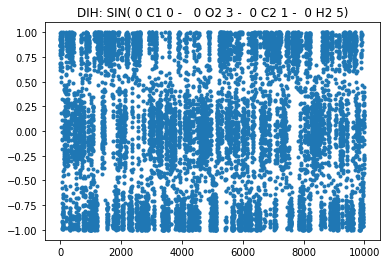

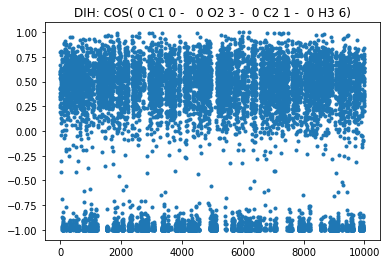

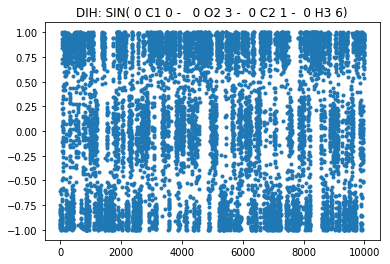

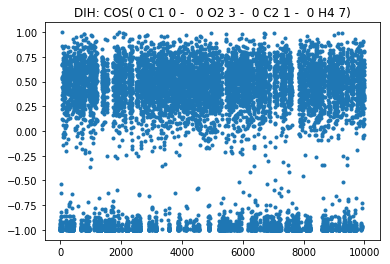

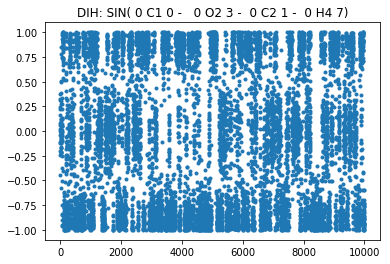

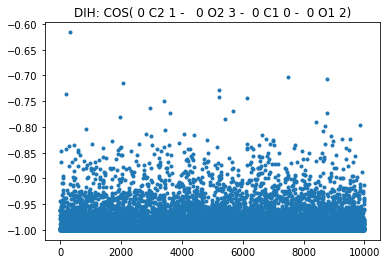

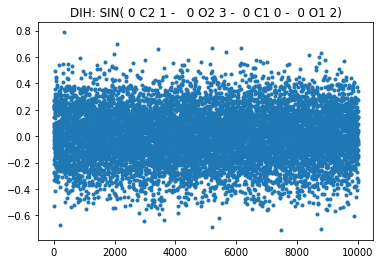

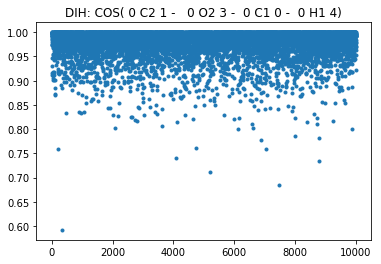

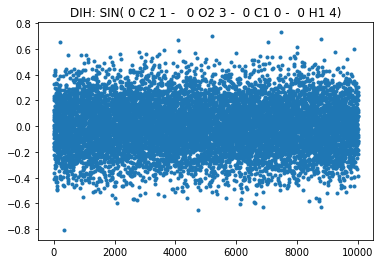

In [52]:
for i in range(len(feat.describe())):
    plt.figure()
    plt.plot(X[:,i], '.')
    plt.title(feat.describe()[i])

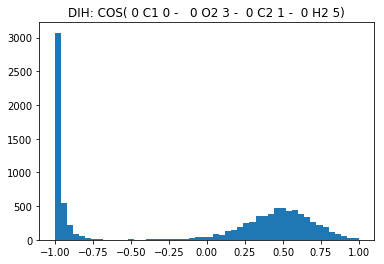

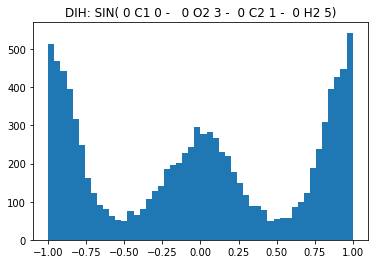

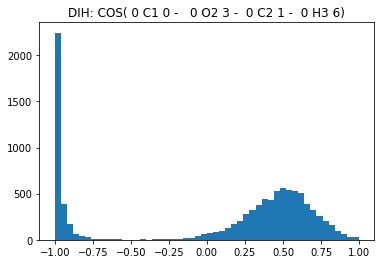

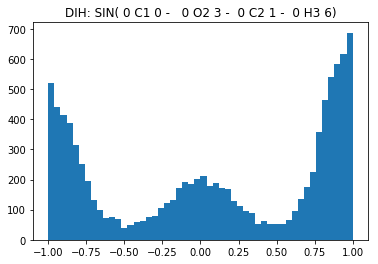

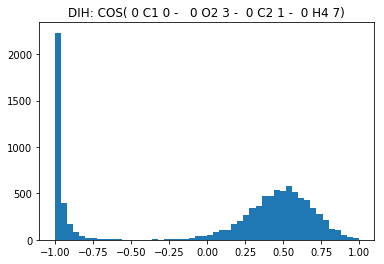

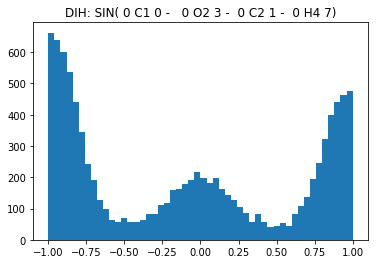

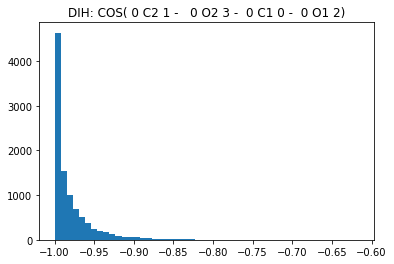

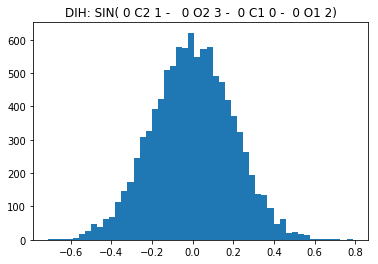

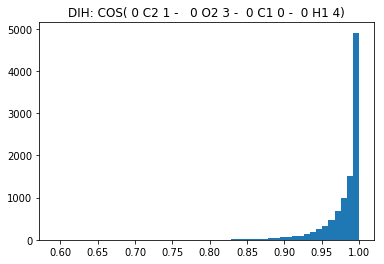

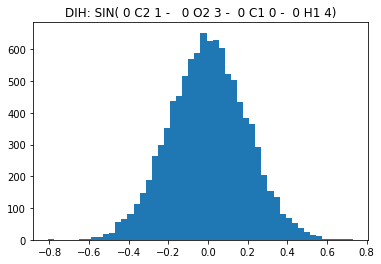

In [53]:
for i in range(len(feat.describe())):
    plt.figure()
    plt.hist(X[:,i], bins=50);
    plt.title(feat.describe()[i])

In [54]:
from pyemma.coordinates import acf

In [55]:
acfs = acf.acf(X.T)

In [56]:
acfs[0]

array([1., 1., 1., ..., 1., 1., 1.])

In [57]:
from statsmodels.tsa.stattools import acf

/Users/joshuafass/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


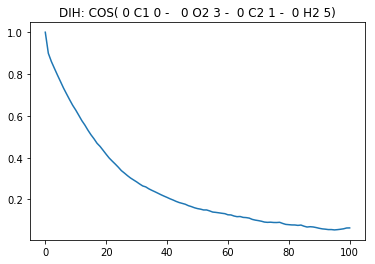

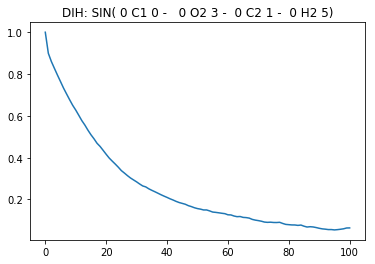

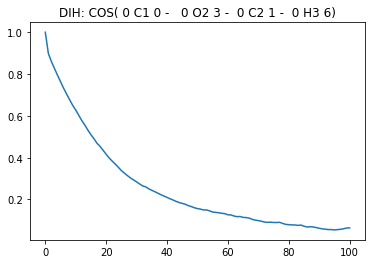

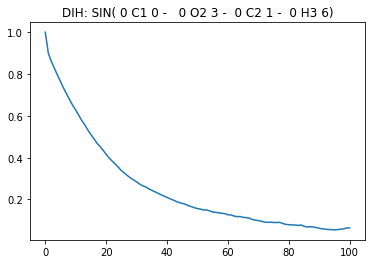

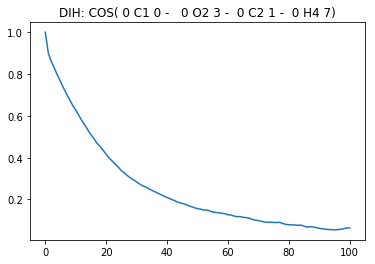

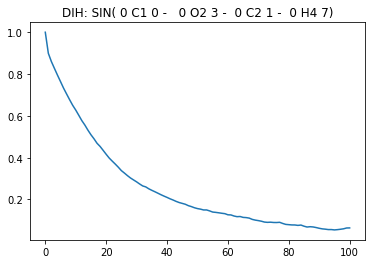

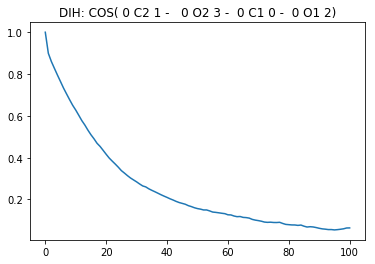

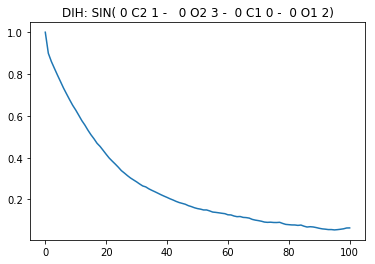

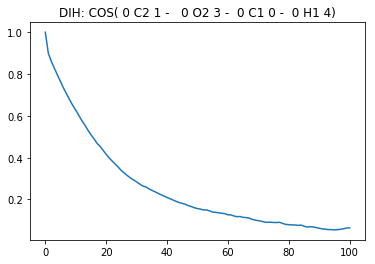

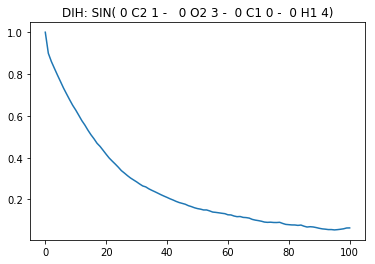

In [58]:
for i in range(len(feat.describe())):
    plt.figure()
    #plt.hist(X[:,i], bins=50);
    plt.plot(acf(X[:,0], nlags=100))
    plt.title(feat.describe()[i])


In [59]:
traj = traj.superpose(traj[5000])

In [60]:
traj[::100].save_pdb('methyl_formate_traj.pdb')

In [63]:
# whew! that could be methyl formate...

[a.element for a in traj.top.atoms]

[(6, 'carbon', 'C', 12.01078, 0.17),
 (6, 'carbon', 'C', 12.01078, 0.17),
 (8, 'oxygen', 'O', 15.99943, 0.152),
 (8, 'oxygen', 'O', 15.99943, 0.152),
 (1, 'hydrogen', 'H', 1.007947, 0.12),
 (1, 'hydrogen', 'H', 1.007947, 0.12),
 (1, 'hydrogen', 'H', 1.007947, 0.12),
 (1, 'hydrogen', 'H', 1.007947, 0.12)]

In [ ]:
# okay

In [66]:
important_inds = [i for i in range(len(feat.describe())) if ('O1' in feat.describe()[i]) and ('O2' in feat.describe()[i])]

In [67]:
[feat.describe()[i] for i in important_inds]

['DIH: COS( 0 C2 1 -   0 O2 3 -  0 C1 0 -  0 O1 2)',
 'DIH: SIN( 0 C2 1 -   0 O2 3 -  0 C1 0 -  0 O1 2)']

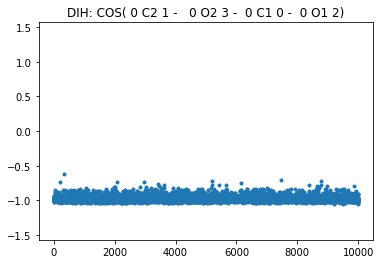

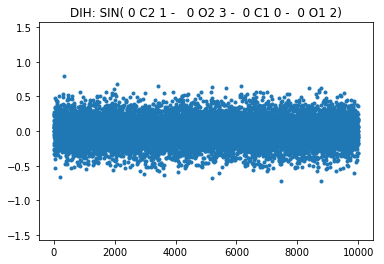

In [70]:
import numpy as np
for i in important_inds:
    plt.figure()
    plt.plot(X[:,i], '.')
    plt.title(feat.describe()[i])
    plt.ylim(-np.pi / 2, np.pi / 2)

In [ ]:
plt.hist()